# Import libraries

In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

# Functions

In [3]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [4]:
import glob

data_directory = "Ravdess"
files = glob.glob(data_directory + "/Actor_*/*.wav")
print("Number of audio files:", len(files))

Number of audio files: 1440


# Extract features from audio files to numpy array

In [5]:
def extract_feature(data, sr, mfcc, chroma, mel):
    
    """
    extract features from audio files into numpy array
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency
    
    """
    
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:                             
        mel = np.mean(librosa.feature.melspectrogram(data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))
        
    return result 

# Data Augmentation Techniques

In [6]:
def noise(data, noise_factor):
    
    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added 

    """
    noise = np.random.randn(len(data)) 
    augmented_data = data + noise_factor * noise
    
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

# Shift the spectogram in a direction

In [7]:
def shift(data, sampling_rate, shift_max, shift_direction):
    
    """
    shift the spectogram in a direction
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
        
    return augmented_data

# Loading dataset

In [8]:
def load_data(save=False, num_files=None):
    """
    Loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy
    num_files : int, the number of files to load

    """
    x, y = [], []
    files = glob.glob(data_directory + "/Actor_*/*.wav")
    if num_files is not None:
        files = files[:num_files]  # Load only the first `num_files` files

    for file in files:

        # load an audio file as a floating point time series.
        data, sr = librosa.load(file)

        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)

        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data, sr, 0.25, 'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y


# Data processing

In [9]:
def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):
    result = np.array([])

    if mfcc:
        mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        result = np.hstack((result, mfccs_mean))

    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, chroma))

    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel))

    return result

X, y = load_data(save=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)


# Encode the data labels

In [10]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [11]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 153


# Model training

In [12]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(153,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
# opt = keras.optimizers.adam(decay=1e-6)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

# Training

In [19]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 [==============================] - 15s 251ms/step - loss: 2.3582 - accuracy: 0.1981 - val_loss: 1.9797 - val_accuracy: 0.2519
Epoch 2/100
51/51 [==============================] - 13s 253ms/step - loss: 1.9815 - accuracy: 0.2701 - val_loss: 1.9120 - val_accuracy: 0.3000
Epoch 3/100
51/51 [==============================] - 11s 216ms/step - loss: 1.8928 - accuracy: 0.3052 - val_loss: 1.8183 - val_accuracy: 0.3639
Epoch 4/100
51/51 [==============================] - 11s 213ms/step - loss: 1.8128 - accuracy: 0.3478 - val_loss: 1.7534 - val_accuracy: 0.3676
Epoch 5/100
51/51 [==============================] - 10s 201ms/step - loss: 1.7367 - accuracy: 0.3701 - val_loss: 1.6842 - val_accuracy: 0.4194
Epoch 6/100
51/51 [==============================] - 10s 195ms/step - loss: 1.6842 - accuracy: 0.3975 - val_loss: 1.6452 - val_accuracy: 0.4481
Epoch 7/100
51/51 [==============================] - 10s 197ms/step - loss: 1.6470 - accuracy: 0.4201 - val_loss: 1.6118 - val_accuracy:

51/51 [==============================] - 17s 326ms/step - loss: 0.4629 - accuracy: 0.9049 - val_loss: 0.8757 - val_accuracy: 0.8463
Epoch 58/100
51/51 [==============================] - 21s 406ms/step - loss: 0.4282 - accuracy: 0.9176 - val_loss: 0.8586 - val_accuracy: 0.8444
Epoch 59/100
51/51 [==============================] - 13s 253ms/step - loss: 0.4403 - accuracy: 0.9160 - val_loss: 0.9512 - val_accuracy: 0.8426
Epoch 60/100
51/51 [==============================] - 11s 207ms/step - loss: 0.4182 - accuracy: 0.9219 - val_loss: 0.9170 - val_accuracy: 0.8639
Epoch 61/100
51/51 [==============================] - 10s 193ms/step - loss: 0.4134 - accuracy: 0.9272 - val_loss: 1.0035 - val_accuracy: 0.8454
Epoch 62/100
51/51 [==============================] - 10s 190ms/step - loss: 0.4136 - accuracy: 0.9247 - val_loss: 0.9269 - val_accuracy: 0.8593
Epoch 63/100
51/51 [==============================] - 9s 185ms/step - loss: 0.4242 - accuracy: 0.9194 - val_loss: 0.9505 - val_accuracy: 0.8611

# Model Evaluation

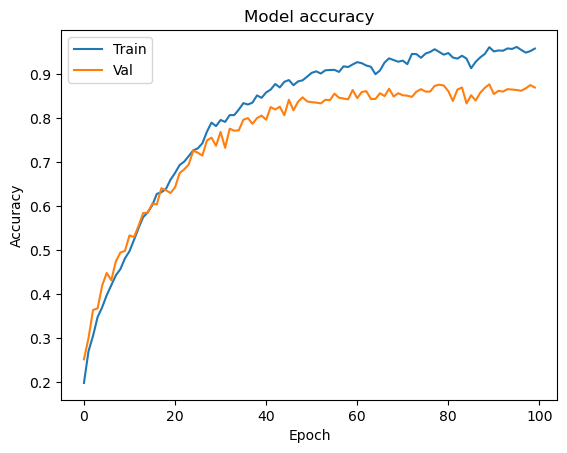

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

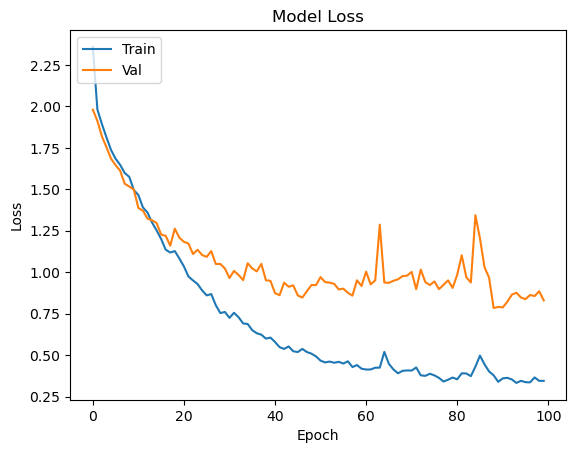

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [22]:
y_pred = model.predict(XTestProcessed)

34/34 [==============================] - 2s 37ms/step


<Axes: >

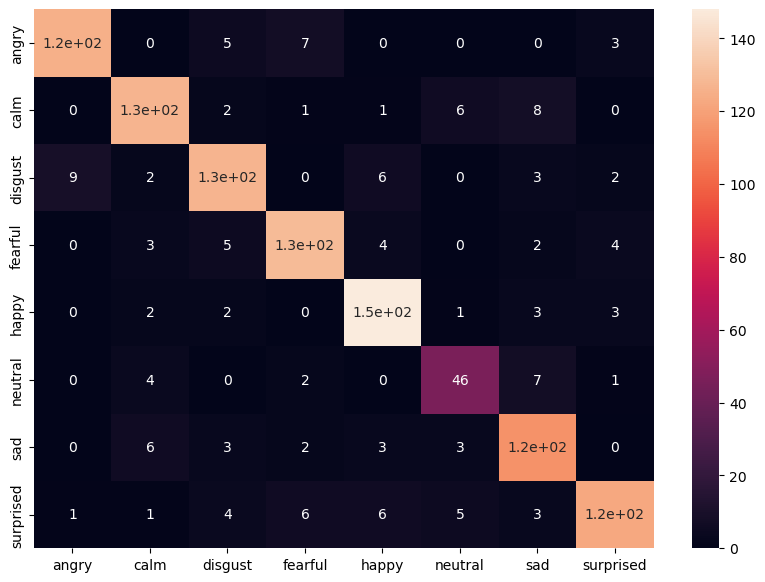

In [23]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [24]:
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

0.8694998225992078

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 153, 256)          1536      
                                                                 
 activation (Activation)     (None, 153, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 153, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 153, 128)          0         
                                                                 
 dropout (Dropout)           (None, 153, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 128)          0         
 )                                                               
                                                        

# Save and load the trained model

In [26]:
# Save the trained model to disk
if not os.path.exists('models'): 
    os.makedirs('models')

model.save("models/cnn.h5")

In [27]:
# Load the model from disk
loaded_model = keras.models.load_model("models/cnn.h5")

# Playground

In [49]:
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [53]:
XX, yy = load_single_data("Ravdess/Actor_01/03-01-01-01-01-01-01.wav")

In [54]:
yy

['neutral']

In [55]:
# # Predict for the test set
# XXTemp=np.expand_dims(XX, axis=2)
# XX, yy = load_single_data("Ravdess/Actor_01/03-01-05-02-02-02-01.wav") = model.predict(XXTemp)
# Predict for the test set
XXTemp = np.expand_dims(XX, axis=2)
XX, yy = load_single_data("Ravdess/Actor_01/03-01-05-02-02-02-01.wav"), model.predict(XXTemp)

1/1 [==============================] - 0s 31ms/step


In [56]:
list(y_pred)

[array([1.8154931e-11, 1.8206358e-11, 4.2575596e-07, 9.9978995e-01,
        1.3649310e-07, 5.0109361e-09, 6.3146366e-08, 2.0955966e-04],
       dtype=float32),
 array([2.3384757e-06, 8.6129927e-05, 2.4203652e-04, 9.9765652e-01,
        1.2721120e-03, 1.0396338e-06, 3.9607185e-04, 3.4373748e-04],
       dtype=float32),
 array([1.2412878e-04, 7.4270129e-01, 3.7210744e-02, 5.6101102e-04,
        2.0897131e-02, 1.3124785e-01, 6.7234673e-02, 2.3222985e-05],
       dtype=float32),
 array([2.5294939e-05, 9.9259585e-01, 2.4736167e-03, 1.0856156e-07,
        5.2335783e-04, 5.7668687e-05, 3.8591940e-03, 4.6489586e-04],
       dtype=float32),
 array([7.59489902e-11, 6.24189779e-05, 8.77519002e-10, 1.56938036e-08,
        2.89141931e-12, 1.61334686e-03, 9.98324215e-01, 1.11701356e-10],
       dtype=float32),
 array([1.0461388e-09, 3.1212113e-16, 2.0383386e-08, 9.3418229e-10,
        3.6870295e-11, 3.8995838e-12, 6.8052801e-13, 9.9999994e-01],
       dtype=float32),
 array([5.94444318e-05, 6.393018

In [57]:
import wave
import librosa

# Replace 'your_audio_file.wav' with the path to your WAV file
wav_file_path = 'Ravdess/Actor_01/03-01-05-02-02-02-01.wav'

# Open the WAV file
with wave.open(wav_file_path, 'rb') as wav_file:
    # Get the WAV file parameters
    num_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()

    # Calculate dataSize (size of audio data excluding the header)
    data_size = num_frames * num_channels * sample_width

    # Calculate byteRate
    byte_rate = frame_rate * num_channels * sample_width
    
    audio_data, sample_rate = librosa.load(wav_file_path, sr=None)

# Print the calculated values
print(f'Data Size: {data_size} bytes')
print(f'Byte Rate: {byte_rate} bytes per second')
print(f'Sample Rate: {sample_rate} Hz')

Data Size: 426026 bytes
Byte Rate: 96000 bytes per second
Sample Rate: 48000 Hz


In [58]:
# Print input and output shapes
print("Input Shape:", model.input_shape)
print("Output Shape:", model.output_shape)

Input Shape: (None, 153, 1)
Output Shape: (None, 8)


In [142]:
import wave
import librosa

# ... (your existing code)

# Open the WAV file
with wave.open(wav_file_path, 'rb') as wav_file:
    # Get the WAV file parameters
    num_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()

    # Calculate dataSize (size of audio data excluding the header)
    data_size = num_frames * num_channels * sample_width

    # Calculate byteRate
    byte_rate = frame_rate * num_channels * sample_width
    
    audio_data, sample_rate = librosa.load(wav_file_path, sr=None)

# Print the calculated values
print(f'Data Size: {data_size} bytes')
print(f'Byte Rate: {byte_rate} bytes per second')
print(f'Sample Rate: {sample_rate} Hz')

# Print input and output shapes
print("Input Shape:", model.input_shape)
print("Output Shape:", model.output_shape)


Data Size: 426026 bytes
Byte Rate: 96000 bytes per second
Sample Rate: 48000 Hz
Input Shape: (None, 153, 1)
Output Shape: (None, 8)


In [140]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your Keras model
model = load_model('models/cnn.h5')

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('speech_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp7ppa9hl4\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp7ppa9hl4\assets
